In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from factor_analyzer import FactorAnalyzer
from fcmeans import FCM
import scikit_posthocs as sci_posthocs

import scipy as sci
import matplotlib
from sklearn.cluster import KMeans

import analysis as ana
import plot as pl

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [4]:
import matplotlib as mpl
from matplotlib import rc

rc('text', usetex=False)
font = {#'family':'CMU Serif', 
               #'sans-serif':['Helvetica'],
               'size': 11}
#mpl.rc('font', **font)

# Loading Data

In [5]:
path = '../../earlypsychosis/data/behavior/Package_1192721/'

ndar_subject = pd.read_csv(path + 'ndar_subject01.txt', sep="\t")
ndar_subject = ndar_subject.drop_duplicates(subset=['subjectkey'], keep='first').iloc[1:]  # drop dublicates and remove description
#ndar_subject['src_subject_id'] = ndar_subject['src_subject_id'].str.strip()
ndar_subject['src_subject_id'] = ndar_subject['src_subject_id'].astype(int)
ndar_subject = ndar_subject.set_index('src_subject_id')  # set index 

In [6]:
cog_data_z, subj_data = ana.load_data('../data_zscore')
cog_data, _ = ana.load_data('../data')

'In good health': 0, 

'Affective psychosis': 1, 

'Non-affective psychosis': 2

In [26]:
subj_data['phenotype_description'].value_counts()

phenotype_description
2    118
0     56
1     52
Name: count, dtype: int64

# PCA

### cognitive features

In [9]:
pca = PCA(5)
pca.fit_transform(cog_data_z)
components = pca.components_
cog_data_z_pca = pca.transform(cog_data_z) # project the original data into the PCA space

# Fuzzy clustering

**partition_coefficient**:
defined on the range from 0 to 1, with 1 being best. It is a metric which tells us how cleanly our data is described by a certain model.


**partition_entropy_coefficient**: The partition entropy (PE) measures the fuzzy degree of final divided clusters by means of the fuzzy partition matrix, and the smaller its value, the better the partition result

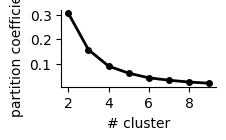

In [8]:
K, pc_list, pec_list = ana.get_partition(cog_data_z_pca, 9)
pl.plot_clustering_validation(K, pc_list, 'partition coefficient')

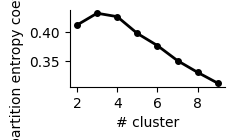

In [10]:
pl.plot_clustering_validation(K, pec_list, 'partition entropy coefficient')

all Data, cog-PCA (z)


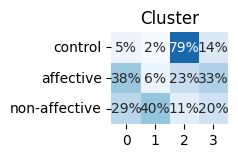

In [8]:
print('all Data, cog-PCA (z)')
predict_4, df = ana.Fuzzy(cog_data_z_pca, 4)
pl.plot_cluster_result(df,4,patients_only=False)
plt.savefig('fig/clu_result4.svg', dpi=500, bbox_inches='tight')

In [7]:
clu_all_result = pd.DataFrame(index=cog_data.index)
clu_all_result['predict_cog'] = predict_4
clu_all_result['phenotype_description'] = subj_data['phenotype_description']
clu_all_result = clu_all_result.join(ndar_subject['subjectkey'], how='left')
clu_all_result.to_csv('clu_results/4clu_result.txt', sep=',')

NameError: name 'predict_4' is not defined

all Data, cog-PCA (z)


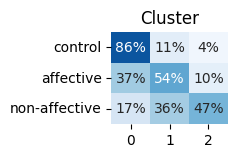

In [10]:
print('all Data, cog-PCA (z)')
predict_3, df = ana.Fuzzy(cog_data_z_pca, 3)
pl.plot_cluster_result(df,3,patients_only=False)
plt.savefig('fig/clu_result3.svg', dpi=500, bbox_inches='tight')

In [11]:
clu_all_result = pd.DataFrame(index=cog_data.index)
clu_all_result['predict_cog'] = predict_3
clu_all_result['phenotype_description'] = subj_data['phenotype_description']
clu_all_result = clu_all_result.join(ndar_subject['subjectkey'], how='left')
clu_all_result.to_csv('clu_results/3clu_result.txt', sep=',')

In [12]:
clu_all_result.groupby(['predict_cog'])['phenotype_description'].value_counts()

predict_cog  phenotype_description
0            0                        48
             2                        20
             1                        19
1            2                        42
             1                        28
             0                         6
2            2                        56
             1                         5
             0                         2
Name: count, dtype: int64

In [ ]:
56
52
118


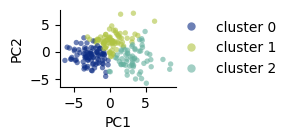

In [200]:
pl.plot_data_2D(cog_data_z_pca, group=predict_3, cluster=True)
plt.savefig('fig/clu_data_cog.svg', dpi=500, bbox_inches='tight')

# Cluster Comparison

## clinical

In [13]:
clinical_data = pd.read_csv('../data/clinical.txt', index_col=0)
clinical_data = clinical_data.reindex(subj_data.index)

In [14]:
clinical_data['cluster'] = predict_3
clinical_data_patients = clinical_data[clinical_data.phenotype_description != 0]
#(clu_0, clu_1, clu_2, clu_3) = 
(clu_0, clu_1, clu_2) = (ana.get_cluster_data(clinical_data_patients, 0), ana.get_cluster_data(clinical_data_patients, 1), ana.get_cluster_data(clinical_data_patients, 2))
#ana.get_cluster_data(clinical_data_patients, 3))
col_panss = ['panss_total','panss_pos','panss_neg','general']
col_panss_names = ['PANSS total', 'PANSS positiv', 'PANSS negativ', 'general psychopathology']
#df_comparison = ana.group_comparison_4cluster(clinical_data_patients, col_panss)
df_comparison = ana.group_comparison(clinical_data_patients, col_panss, cluster=True)

In [15]:
df_comparison

,panss_total,panss_pos,panss_neg,general
test,,,,
group,"[36.2777, 0.0]","[8.9995, 0.0111]","[38.0553, 0.0]","[29.5877, 0.0]"
0-1,"[10.9859, 0.0013]","[4.5791, 0.0285]","[1.8043, 0.1906]","[19.0309, 0.0]"
0-2,"[34.3385, 0.0]","[9.1606, 0.003]","[29.9315, 0.0]","[28.493, 0.0]"
1-2,"[11.6116, 0.0009]","[0.8726, 0.3284]","[24.8542, 0.0]","[0.7324, 0.341]"


In [16]:
print(df_comparison.T.to_latex(index=True))  

\begin{tabular}{lllll}
\toprule
test & group & 0-1 & 0-2 & 1-2 \\
\midrule
panss_total & [36.2777, 0.0] & [10.9859, 0.0013] & [34.3385, 0.0] & [11.6116, 0.0009] \\
panss_pos & [8.9995, 0.0111] & [4.5791, 0.0285] & [9.1606, 0.003] & [0.8726, 0.3284] \\
panss_neg & [38.0553, 0.0] & [1.8043, 0.1906] & [29.9315, 0.0] & [24.8542, 0.0] \\
general & [29.5877, 0.0] & [19.0309, 0.0] & [28.493, 0.0] & [0.7324, 0.341] \\
\bottomrule
\end{tabular}



*   0.05
**  0.01
*** 0.001

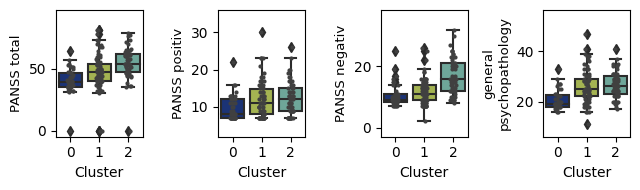

In [207]:
pl.plot_boxplots(clinical_data_patients, col_panss, col_panss_names, 1,4) #5,2
plt.savefig('fig/clu_panss.svg', dpi=500, bbox_inches='tight')

## medication

In [17]:
med_data = pd.read_csv('../data/med.txt', index_col=0)
med_data['cluster'] = predict_3
med_data_patients = med_data[med_data.phenotype_description != 0]
#(med_0, med_1, med_2, med_3) = 
(med_0, med_1, med_2) = (ana.get_cluster_data(med_data_patients, 0), 
                                ana.get_cluster_data(med_data_patients, 1), 
                                ana.get_cluster_data(med_data_patients, 2)) 
                                #ana.get_cluster_data(med_data_patients, 3))
col_med = ['apd_exp_months', 'apd_chlor_equiv', 'apd_date_equiv']
col_med_names = ['Lifetime Antipsychotic Drug Exposure (months)',
'Chlorpromazine Equivalence (mg/d)',
'Scan Date Chlorpromazine Equivalence (mg)']
df_comparison_med = ana.group_comparison(med_data_patients, col_med, cluster=True)

In [26]:
df_comparison_med.T

test,group,0-1,0-2,1-2
apd_exp_months,"[7.2749, 0.0263]","[0.9509, 0.3351]","[1.8231, 0.1762]","[7.2484, 0.0074]"
apd_chlor_equiv,"[29.132, 0.0]","[0.4052, 0.5436]","[12.5926, 0.0002]","[25.8164, 0.0]"
apd_date_equiv,"[25.9395, 0.0]","[0.1939, 0.6888]","[12.1334, 0.0002]","[22.0764, 0.0]"


In [19]:
print(df_comparison_med.T.to_latex(index=True))  

\begin{tabular}{lllll}
\toprule
test & group & 0-1 & 0-2 & 1-2 \\
\midrule
apd_exp_months & [7.2749, 0.0263] & [0.9509, 0.3351] & [1.8231, 0.1762] & [7.2484, 0.0074] \\
apd_chlor_equiv & [29.132, 0.0] & [0.4052, 0.5436] & [12.5926, 0.0002] & [25.8164, 0.0] \\
apd_date_equiv & [25.9395, 0.0] & [0.1939, 0.6888] & [12.1334, 0.0002] & [22.0764, 0.0] \\
\bottomrule
\end{tabular}



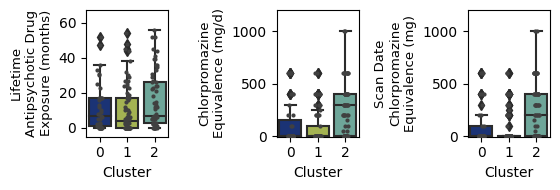

In [321]:
pl.plot_boxplots(med_data_patients, col_med, col_med_names, 1,3)
plt.savefig('fig/clu_med.svg', dpi=500, bbox_inches='tight')

## cognitive 

In [20]:
cog_data_cluster = cog_data.copy()
cog_data_cluster['cluster'] = predict_3
cog_data_cluster.loc[subj_data.phenotype == 0, 'cluster'] = 'c'
clu_0, clu_1, clu_2, con = ana.get_cluster_data(cog_data_cluster, 0), ana.get_cluster_data(cog_data_cluster, 1), ana.get_cluster_data(cog_data_cluster, 2), ana.get_cluster_data(cog_data_cluster, 'c')
col_cog = list(cog_data.columns)[4:]
#col_cog_names = []
df_comparison = ana.group_comparison_control(cog_data_cluster, col_cog)
#df_comparison.columns = col_cog_names

In [21]:
df_comparison.T

test,group,0-1,0-2,0-c,1-2,1-c,2-c
cgi01_gaf2a,"[90.9585, 0.0]","[22.1896, 0.0]","[16.8475, 0.0002]","[16.4083, 0.0015]","[0.4969, 0.5805]","[64.5288, 0.0]","[57.9353, 0.0]"
cgi01_gaf2b1,"[78.1465, 0.0]","[14.2375, 0.0006]","[13.3187, 0.001]","[17.5608, 0.0007]","[0.0634, 0.9493]","[53.5162, 0.0]","[55.026, 0.0]"
cgi01_gaf2b2,"[6.1672, 0.1038]",-,-,-,-,-,-
cgi01_gaf2c,"[90.8192, 0.0]","[27.045, 0.0]","[32.1442, 0.0]","[7.0905, 0.0631]","[0.8396, 0.4523]","[55.1229, 0.0]","[57.138, 0.0]"
cogcomp01_nih_fluidcogcomp_unadjusted,"[87.649, 0.0]","[3.3894, 0.1012]","[44.3611, 0.0]","[3.3996, 0.1504]","[40.0851, 0.0]","[15.5651, 0.0005]","[64.5597, 0.0]"
cogcomp01_nih_crycogcomp_unadjusted,"[112.1136, 0.0]","[0.1258, 0.8385]","[63.2746, 0.0]","[0.4596, 0.7076]","[84.5395, 0.0]","[0.2614, 0.8344]","[66.9227, 0.0]"
dccs01_nih_dccs_ageadjusted,"[54.7055, 0.0]","[1.9977, 0.219]","[27.6009, 0.0]","[0.6619, 0.4616]","[27.3806, 0.0]","[5.8383, 0.026]","[42.6152, 0.0]"
deldisk01_auc_200,"[14.7643, 0.002]","[0.9172, 0.3689]","[8.8539, 0.0009]","[0.838, 0.5272]","[8.2377, 0.0042]","[0.0544, 0.7903]","[10.2426, 0.003]"
deldisk01_auc_40000,"[30.8906, 0.0]","[1.4584, 0.2387]","[17.4767, 0.0]","[0.0662, 0.9614]","[14.8141, 0.0001]","[1.568, 0.2087]","[24.9015, 0.0]"
flanker01_nih_flanker_ageadjusted,"[64.5138, 0.0]","[4.7476, 0.0505]","[29.5959, 0.0]","[0.8882, 0.3116]","[26.6117, 0.0]","[14.8705, 0.0008]","[49.07, 0.0]"


In [222]:
df_comparison.T.to_csv('clu_results_cog_all.csv', sep=',')

In [ ]:
#####################################################################

In [33]:
print(df_comparison.T.to_latex(index=True))  

\begin{tabular}{llllllll}
\toprule
test & group & 0-1 & 0-2 & 0-c & 1-2 & 1-c & 2-c \\
\midrule
cgi01_gaf2a & [90.9585, 0.0] & [22.1896, 0.0] & [16.8475, 0.0002] & [16.4083, 0.0015] & [0.4969, 0.5805] & [64.5288, 0.0] & [57.9353, 0.0] \\
cgi01_gaf2b1 & [78.1465, 0.0] & [14.2375, 0.0006] & [13.3187, 0.001] & [17.5608, 0.0007] & [0.0634, 0.9493] & [53.5162, 0.0] & [55.026, 0.0] \\
cgi01_gaf2b2 & [6.1672, 0.1038] & - & - & - & - & - & - \\
cgi01_gaf2c & [90.8192, 0.0] & [27.045, 0.0] & [32.1442, 0.0] & [7.0905, 0.0631] & [0.8396, 0.4523] & [55.1229, 0.0] & [57.138, 0.0] \\
cogcomp01_nih_fluidcogcomp_unadjusted & [87.649, 0.0] & [3.3894, 0.1012] & [44.3611, 0.0] & [3.3996, 0.1504] & [40.0851, 0.0] & [15.5651, 0.0005] & [64.5597, 0.0] \\
cogcomp01_nih_crycogcomp_unadjusted & [112.1136, 0.0] & [0.1258, 0.8385] & [63.2746, 0.0] & [0.4596, 0.7076] & [84.5395, 0.0] & [0.2614, 0.8344] & [66.9227, 0.0] \\
dccs01_nih_dccs_ageadjusted & [54.7055, 0.0] & [1.9977, 0.219] & [27.6009, 0.0] & [0.6619, 0

In [22]:
cog_data_cluster = cog_data.copy()
cog_data_cluster['cluster'] = predict_3
cog_data_cluster.loc[subj_data.phenotype == 0, 'cluster'] = 'c'
col_cog = ['cogcomp01_nih_fluidcogcomp_unadjusted',
       'cogcomp01_nih_crycogcomp_unadjusted', 'wasi201_iqscores_full2iq',
       'tpvt01_tpvt_acss', 'orrt01_read_acss', 'acpt01_%Hits',
       'lswmt01_tbx_ls', 'wasi201_vocab_totalrawscore',
       'wasi201_matrix_totalrawscore', 'dccs01_nih_dccs_ageadjusted']
col_cog_names = ['Fluid cognition', 'Crystallized cognition', 'Total IQ', 'Picture vocabulary test', 'Oral reading recognition', 'Auditory attention %correct', 'Working memory', 'WASI - Verbal comprehension', 'WASI - Matrix reasoning', 'DCCS - Executive functioning']

In [23]:
clu_0, clu_1, clu_2, con = ana.get_cluster_data(cog_data_cluster, 0), ana.get_cluster_data(cog_data_cluster, 1), ana.get_cluster_data(cog_data_cluster, 2), ana.get_cluster_data(cog_data_cluster, 'c')
df_comparison = ana.group_comparison_control(cog_data_cluster, col_cog)
df_comparison.columns = col_cog_names

In [24]:
df_comparison

,Fluid cognition,Crystallized cognition,Total IQ,Picture vocabulary test,Oral reading recognition,Auditory attention %correct,Working memory,WASI - Verbal comprehension,WASI - Matrix reasoning,DCCS - Executive functioning
test,,,,,,,,,,
group,"[87.649, 0.0]","[112.1136, 0.0]","[108.7698, 0.0]","[101.079, 0.0]","[92.0641, 0.0]","[74.1838, 0.0]","[71.9626, 0.0]","[94.1753, 0.0]","[69.0919, 0.0]","[54.7055, 0.0]"
0-1,"[3.3894, 0.1012]","[0.1258, 0.8385]","[0.0548, 0.7688]","[0.002, 0.9896]","[0.135, 0.7528]","[0.0846, 0.7981]","[0.6076, 0.4955]","[0.0008, 0.9558]","[0.666, 0.5129]","[1.9977, 0.219]"
0-2,"[44.3611, 0.0]","[63.2746, 0.0]","[57.5106, 0.0]","[57.5472, 0.0]","[47.5712, 0.0]","[31.6126, 0.0]","[32.4261, 0.0]","[51.1362, 0.0]","[32.4274, 0.0]","[27.6009, 0.0]"
0-c,"[3.3996, 0.1504]","[0.4596, 0.7076]","[0.7714, 0.4455]","[0.1995, 0.8805]","[0.4502, 0.6092]","[11.0381, 0.0099]","[1.8983, 0.2301]","[0.0435, 0.8611]","[2.7553, 0.17]","[0.6619, 0.4616]"
1-2,"[40.0851, 0.0]","[84.5395, 0.0]","[74.8416, 0.0]","[77.0475, 0.0]","[68.125, 0.0]","[33.1923, 0.0]","[51.8415, 0.0]","[68.2115, 0.0]","[38.7849, 0.0]","[27.3806, 0.0]"
1-c,"[15.5651, 0.0005]","[0.2614, 0.8344]","[2.5123, 0.2243]","[0.1954, 0.8726]","[0.1255, 0.8075]","[12.2936, 0.001]","[0.6073, 0.5245]","[0.0341, 0.8873]","[6.9518, 0.02]","[5.8383, 0.026]"
2-c,"[64.5597, 0.0]","[66.9227, 0.0]","[73.4878, 0.0]","[59.3365, 0.0]","[59.9688, 0.0]","[57.8224, 0.0]","[50.0042, 0.0]","[60.9508, 0.0]","[51.9111, 0.0]","[42.6152, 0.0]"


In [25]:
print(df_comparison.T.to_latex(index=True))  

\begin{tabular}{llllllll}
\toprule
test & group & 0-1 & 0-2 & 0-c & 1-2 & 1-c & 2-c \\
\midrule
Fluid cognition & [87.649, 0.0] & [3.3894, 0.1012] & [44.3611, 0.0] & [3.3996, 0.1504] & [40.0851, 0.0] & [15.5651, 0.0005] & [64.5597, 0.0] \\
Crystallized cognition & [112.1136, 0.0] & [0.1258, 0.8385] & [63.2746, 0.0] & [0.4596, 0.7076] & [84.5395, 0.0] & [0.2614, 0.8344] & [66.9227, 0.0] \\
Total IQ & [108.7698, 0.0] & [0.0548, 0.7688] & [57.5106, 0.0] & [0.7714, 0.4455] & [74.8416, 0.0] & [2.5123, 0.2243] & [73.4878, 0.0] \\
Picture vocabulary test & [101.079, 0.0] & [0.002, 0.9896] & [57.5472, 0.0] & [0.1995, 0.8805] & [77.0475, 0.0] & [0.1954, 0.8726] & [59.3365, 0.0] \\
Oral reading recognition & [92.0641, 0.0] & [0.135, 0.7528] & [47.5712, 0.0] & [0.4502, 0.6092] & [68.125, 0.0] & [0.1255, 0.8075] & [59.9688, 0.0] \\
Auditory attention %correct & [74.1838, 0.0] & [0.0846, 0.7981] & [31.6126, 0.0] & [11.0381, 0.0099] & [33.1923, 0.0] & [12.2936, 0.001] & [57.8224, 0.0] \\
Working mem

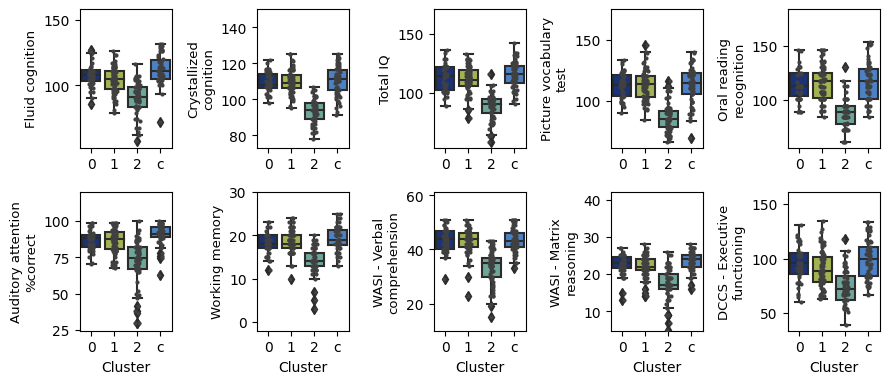

In [232]:
pl.plot_boxplots(cog_data_cluster, col_cog, col_cog_names, control=True)
plt.savefig('fig/clu_cog.svg', dpi=500, bbox_inches='tight')

## selected features

In [17]:
cog_data_cluster = cog_data.copy()
cog_data_cluster['cluster'] = predict_all
cog_data_cluster.loc[subj_data.phenotype == 0, 'cluster'] = 'c'
col_cog = list(cog_data.columns)[4:]
df_comparison = ana.group_comparison_control(cog_data_cluster, col_cog)

In [25]:
#print(df_comparison.T.to_latex(index=True))  

In [18]:
col_cog_repr = ['flanker01_nih_flanker_ageadjusted',
'lswmt01_tbx_ls',
'orrt01_read_acss',
'pcps01_nih_patterncomp_ageadjusted',
'tpvt01_tpvt_acss',
'wasi201_vocab_totalrawscore',
'wasi201_matrix_totalrawscore',
'wasi201_iqscores_full2iq',
'cogcomp01_nih_fluidcogcomp_unadjusted',
'cogcomp01_nih_crycogcomp_unadjusted',
'deldisk01_auc_40000',
'dccs01_nih_dccs_ageadjusted',
'er4001_er40_c_cr',
'acpt01_auditory_t14']
col_cog_names_repr = ['Selective attention/ executive control (Age Adj.)', 
'Working memory',
'Oral reading recognition', 
'Pattern Comparison Processing Speed (Age Adj.)',
'Picture Vocabulary Test (Age Adj.)',
'WASI-2 Total - Vocabulary',                  
'WASI-2 Total - Matrix Reasoning',                      
'WASI-2 Full IQ',
'Fluid cognition',
'Crystallized cognition',
'Delay Discounting Task AUC \$40000', #Delay Discounting Task Area Under the Curve for Delay Amount \$40000
'Dimensional Change Card Sort Test (Age Adj.)', #Age Adjusted scaled score for Dimensional Change Card Sort Test subtest  
'Penn Emotion Recognition Task Correct Responses',
'Auditory attention %Hits']

In [19]:
df_comparison = ana.group_comparison_control(cog_data_cluster, col_cog_repr)
df_comparison

,flanker01_nih_flanker_ageadjusted,lswmt01_tbx_ls,orrt01_read_acss,pcps01_nih_patterncomp_ageadjusted,tpvt01_tpvt_acss,wasi201_vocab_totalrawscore,wasi201_matrix_totalrawscore,wasi201_iqscores_full2iq,cogcomp01_nih_fluidcogcomp_unadjusted,cogcomp01_nih_crycogcomp_unadjusted,deldisk01_auc_40000,dccs01_nih_dccs_ageadjusted,er4001_er40_c_cr,acpt01_auditory_t14
test,,,,,,,,,,,,,,
group,"[47.846, 0.0]","[53.3758, 0.0]","[70.2308, 0.0]","[23.0322, 0.0]","[72.5704, 0.0]","[63.7426, 0.0]","[52.0876, 0.0]","[73.7482, 0.0]","[67.3415, 0.0]","[81.0281, 0.0]","[58.1215, 0.0]","[42.7631, 0.0]","[33.827, 0.0]","[64.2906, 0.0]"
0-1,"[0.5109, 0.5429]","[2.0384, 0.1997]","[0.7475, 0.4511]","[1.447, 0.2354]","[1.7709, 0.3024]","[1.0729, 0.3139]","[0.49, 0.5084]","[1.0251, 0.3126]","[1.8304, 0.3128]","[2.8433, 0.2392]","[32.1893, 0.0]","[0.2892, 0.6112]","[0.7642, 0.3739]","[1.3525, 0.2834]"
0-2,"[22.5686, 0.0]","[36.6332, 0.0]","[45.4593, 0.0]","[10.4729, 0.0011]","[47.3309, 0.0]","[38.9171, 0.0]","[27.6299, 0.0]","[43.3934, 0.0]","[35.0173, 0.0]","[51.8509, 0.0]","[36.5371, 0.0]","[21.0286, 0.0]","[16.1314, 0.0001]","[28.7995, 0.0]"
0-c,"[1.2216, 0.252]","[0.0733, 0.7344]","[0.8578, 0.4547]","[0.8921, 0.3406]","[0.0077, 0.9086]","[0.0721, 0.7834]","[2.8483, 0.1754]","[1.4479, 0.3366]","[1.8349, 0.2555]","[0.0481, 0.7143]","[7.0386, 0.0266]","[1.9385, 0.2087]","[1.3997, 0.2514]","[2.8254, 0.0956]"
1-2,"[20.0192, 0.0001]","[21.1106, 0.0]","[34.7952, 0.0]","[3.4935, 0.0701]","[36.044, 0.0]","[24.0036, 0.0]","[17.7603, 0.0001]","[26.8764, 0.0]","[27.1038, 0.0]","[42.0413, 0.0]","[0.622, 0.7487]","[15.1413, 0.0002]","[7.7718, 0.0049]","[21.5207, 0.0001]"
1-c,"[4.7786, 0.0839]","[1.3684, 0.2959]","[0.0125, 0.9228]","[4.8505, 0.0306]","[1.8664, 0.3223]","[1.8752, 0.183]","[4.853, 0.0474]","[5.0548, 0.0475]","[6.5861, 0.0317]","[1.6186, 0.364]","[17.053, 0.0001]","[3.6779, 0.0841]","[4.1371, 0.0425]","[11.0376, 0.0066]"
2-c,"[38.8768, 0.0]","[37.001, 0.0]","[47.8634, 0.0]","[20.6746, 0.0]","[48.0904, 0.0]","[50.1769, 0.0]","[41.5867, 0.0]","[57.2238, 0.0]","[52.1049, 0.0]","[52.9568, 0.0]","[23.5871, 0.0]","[35.7623, 0.0]","[30.6823, 0.0]","[52.916, 0.0]"


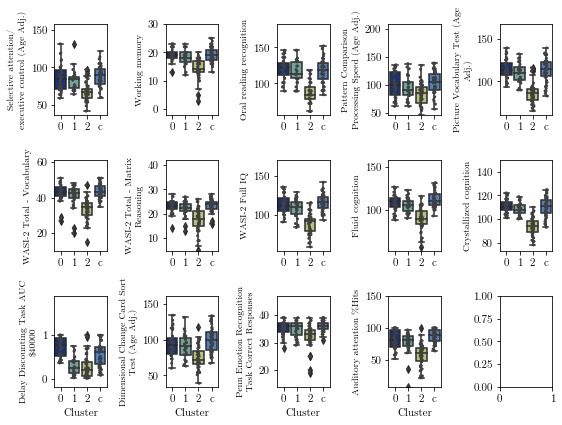

In [20]:
pl.plot_boxplots(cog_data_cluster, col_cog_repr, col_cog_names_repr, 3,5,control=True)
plt.savefig('fig/clu_cog_repr.svg', dpi=500, bbox_inches='tight')

## without control

In [216]:
cog_data_cluster = cog_data.copy()
subj_data_pat = subj_data[subj_data.phenotype != 0]
cog_data_cluster_pat = cog_data_cluster[subj_data.phenotype != 0]
cog_data_cluster_con = cog_data_cluster[subj_data.phenotype == 0]

In [217]:
cog_data_cluster['cluster'] = predict_3
cog_data_cluster = cog_data_cluster[subj_data.phenotype != 0]
clu_0, clu_1, clu_2 = ana.get_cluster_data(cog_data_cluster, 0), ana.get_cluster_data(cog_data_cluster, 1), ana.get_cluster_data(cog_data_cluster, 2)
col_cog = ['cogcomp01_nih_fluidcogcomp_unadjusted',
       'cogcomp01_nih_crycogcomp_unadjusted', 'wasi201_iqscores_full2iq',
       'tpvt01_tpvt_acss', 'orrt01_read_acss', 'acpt01_%Hits',
       'lswmt01_tbx_ls', 'wasi201_vocab_totalrawscore',
       'wasi201_matrix_totalrawscore', 'dccs01_nih_dccs_ageadjusted']
col_cog_names = ['Fluid cognition', 'Crystallized cognition', 'Total IQ', 'Picture vocabulary test', 'Oral reading recognition', 'Auditory attention %Hits', 'Working memory', 'WASI - Verbal comprehension', 'WASI - Matrix reasoning', 'DCCS - Executive functioning']
df_comparison = ana.group_comparison(cog_data_cluster, col_cog, cluster=True)
df_comparison.columns = col_cog_names

In [218]:
df_comparison

,Fluid cognition,Crystallized cognition,Total IQ,Picture vocabulary test,Oral reading recognition,Auditory attention %Hits,Working memory,WASI - Verbal comprehension,WASI - Matrix reasoning,DCCS - Executive functioning
test,,,,,,,,,,
group,"[59.2494, 0.0]","[102.6513, 0.0]","[91.7576, 0.0]","[93.4169, 0.0]","[80.6571, 0.0]","[44.3062, 0.0]","[59.5309, 0.0]","[82.8762, 0.0]","[49.5262, 0.0]","[38.63, 0.0]"
0-1,"[3.3894, 0.0998]","[0.1258, 0.8505]","[0.0548, 0.8225]","[0.002, 0.9954]","[0.135, 0.7703]","[0.0846, 0.6547]","[0.6076, 0.5087]","[0.0008, 0.955]","[0.666, 0.5086]","[1.9977, 0.2307]"
0-2,"[44.3611, 0.0]","[63.2746, 0.0]","[57.5106, 0.0]","[57.5472, 0.0]","[47.5712, 0.0]","[31.6126, 0.0]","[32.4261, 0.0]","[51.1362, 0.0]","[32.4274, 0.0]","[27.6009, 0.0]"
1-2,"[40.0851, 0.0]","[84.5395, 0.0]","[74.8416, 0.0]","[77.0475, 0.0]","[68.125, 0.0]","[33.1923, 0.0]","[51.8415, 0.0]","[68.2115, 0.0]","[38.7849, 0.0]","[27.3806, 0.0]"


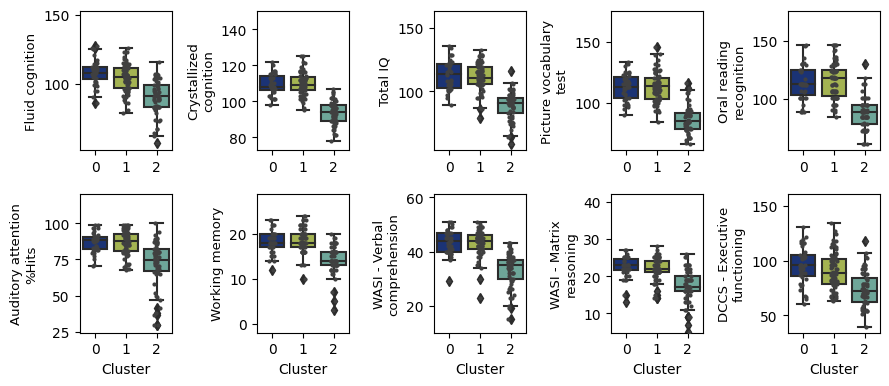

In [219]:
pl.plot_boxplots(cog_data_cluster, col_cog, col_cog_names)
plt.savefig('fig/clu_cog.svg', dpi=500, bbox_inches='tight')

## brain networks

In [27]:
brain_data = pd.read_csv('../data/braindata.txt', index_col=0)
brain_subj_description = pd.read_csv('../data/brain_subj_description.txt', index_col=0)

In [28]:
brain_data_clu = brain_data.join(clinical_data['cluster'], how='left')
brain_data_clu['cluster_c'] = brain_data_clu.loc[:, 'cluster']

In [29]:
brain_data_clu.loc[subj_data.phenotype == 0, 'cluster_c'] = 'c'

In [30]:
brain_data_clu.to_csv('clu_results/3clu_result_brain.txt', sep=',')

In [51]:
brain_data_clu['cluster'] = brain_data_clu['cluster_c']

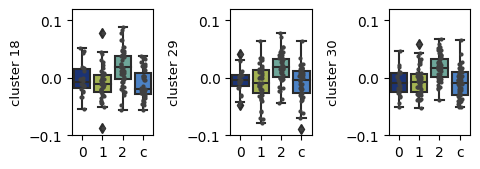

In [86]:
pl.plot_boxplots(brain_data_clu, ['18','29','30'], ['cluster 18','cluster 29','cluster 30'], 1,3, control=True)
plt.savefig('fig/clu_brain.svg', dpi=500, bbox_inches='tight')

In [ ]:
cog_data_cluster = cog_data.copy()
cog_data_cluster['cluster'] = predict_3
cog_data_cluster.loc[subj_data.phenotype == 0, 'cluster'] = 'c'
clu_0, clu_1, clu_2, con = ana.get_cluster_data(cog_data_cluster, 0), ana.get_cluster_data(cog_data_cluster, 1), ana.get_cluster_data(cog_data_cluster, 2), ana.get_cluster_data(cog_data_cluster, 'c')
col_cog = list(cog_data.columns)[4:]
#col_cog_names = []
df_comparison = ana.group_comparison_control(cog_data_cluster, col_cog)
#df_comparison.columns = col_cog_names

In [78]:
(clu_0, clu_1, clu_2, con) = (ana.get_cluster_data(brain_data_clu, 0), ana.get_cluster_data(brain_data_clu, 1), ana.get_cluster_data(brain_data_clu, 2), ana.get_cluster_data(brain_data_clu, 'c'))
col = ['18','29', '30']
col_names = ['cluster 18','cluster 29','cluster 30']
df_comparison = ana.group_comparison_control(brain_data_clu, col)
df_comparison.columns = col_names


In [79]:
df_comparison.T

test,group,0-1,0-2,0-c,1-2,1-c,2-c
cluster 18,"[23.0278, 0.0]","[0.5399, 0.5008]","[7.1728, 0.012]","[1.0878, 0.3514]","[15.5068, 0.0001]","[0.1411, 0.7608]","[17.3921, 0.0]"
cluster 29,"[24.305, 0.0]","[0.1401, 0.8443]","[11.0358, 0.0015]","[0.028, 0.8675]","[15.5068, 0.0]","[0.0119, 0.9684]","[17.9004, 0.0]"
cluster 30,"[30.4236, 0.0]","[0.0233, 0.7786]","[15.1209, 0.0002]","[0.0015, 0.9647]","[17.7453, 0.0]","[0.1664, 0.6867]","[22.9485, 0.0]"


In [87]:
print(df_comparison.T.to_latex(index=True))  

\begin{tabular}{llllllll}
\toprule
test & group & 0-1 & 0-2 & 0-c & 1-2 & 1-c & 2-c \\
\midrule
cluster 18 & [23.0278, 0.0] & [0.5399, 0.5008] & [7.1728, 0.012] & [1.0878, 0.3514] & [15.5068, 0.0001] & [0.1411, 0.7608] & [17.3921, 0.0] \\
cluster 29 & [24.305, 0.0] & [0.1401, 0.8443] & [11.0358, 0.0015] & [0.028, 0.8675] & [15.5068, 0.0] & [0.0119, 0.9684] & [17.9004, 0.0] \\
cluster 30 & [30.4236, 0.0] & [0.0233, 0.7786] & [15.1209, 0.0002] & [0.0015, 0.9647] & [17.7453, 0.0] & [0.1664, 0.6867] & [22.9485, 0.0] \\
\bottomrule
\end{tabular}



# K-Means Clustering

**Intertia**:
measures how well a dataset was clustered by K-Means. It is calculated by measuring the distance between each data point and its centroid, squaring this distance, and summing these squares across one cluster. A good model is one with low inertia AND a low number of clusters ( K ).

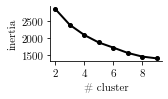

In [303]:
K, inertia = ana.get_intertia(cog_data_z_pca, 9)
pl.plot_clustering_validation(K, inertia)

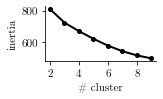

In [304]:
K, inertia = ana.get_intertia(brain_data_z_fa, 9)
pl.plot_clustering_validation(K, inertia)

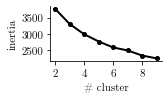

In [305]:
K, inertia = ana.get_intertia(all_data_z_pcafa, 9)
pl.plot_clustering_validation(K, inertia)

Cognitive Data, PCA
K-Means


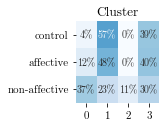

Spectral


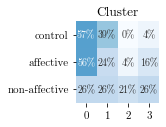

In [120]:
k=4
print('Cognitive Data, PCA')
print('K-Means')
predict, df = ana.K_Means(cog_data_z_pca, k)
pl.plot_cluster_result(df, k)
plt.show()

print('Spectral')
predict, df = ana.Spectral(cog_data_z_pca, k)
pl.plot_cluster_result(df, k)

Brain Data, FA
K-Means


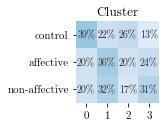

Spectral


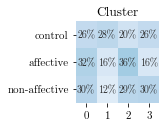

In [122]:
k=4
print('Brain Data, FA')
print('K-Means')
predict, df = ana.K_Means(brain_data_z_fa, k)
pl.plot_cluster_result(df, k)
plt.show()

print('Spectral')
predict, df = ana.Spectral(brain_data_z_fa, k)
pl.plot_cluster_result(df, k)

all Data, cog-PCA (z), brain-FA (z)
K-Means


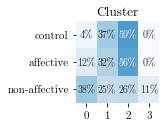

Spectral


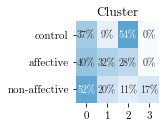

In [123]:
k=4
print('all Data, cog-PCA (z), brain-FA (z)')
print('K-Means')
predict, df = ana.K_Means(all_data_z_pcafa, k)
pl.plot_cluster_result(df, k)
plt.show()

print('Spectral')
predict, df = ana.Spectral(all_data_z_pcafa, k)
pl.plot_cluster_result(df, k)

all Data, cog-PCA (z), brain-FA (z)
K-Means


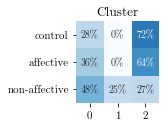

Spectral


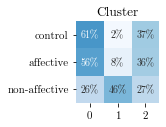

In [196]:
k=3
print('all Data, cog-PCA (z), brain-FA (z)')
print('K-Means')
predict, df = ana.K_Means(all_data_z_pcafa, k)
pl.plot_cluster_result(df, k)
plt.show()

print('Spectral')
predict_spectral, df = ana.Spectral(all_data_z_pcafa, k)
pl.plot_cluster_result(df, k)